In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import plotly.express as px

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

In [2]:
df = pd.read_csv('BTC Cap Active.csv', index_col=0, parse_dates=True)

display(df)

,Market_Cap,No_addresses
Date,,
2010-07-17,1.698390e+05,390
2010-07-18,2.497610e+05,424
2010-07-19,2.959810e+05,553
2010-07-20,2.705460e+05,632
2010-07-21,2.659000e+05,440
...,...,...
2025-01-29,2.076760e+12,386071
2025-01-30,2.028500e+12,392342
2025-01-31,1.996420e+12,382380


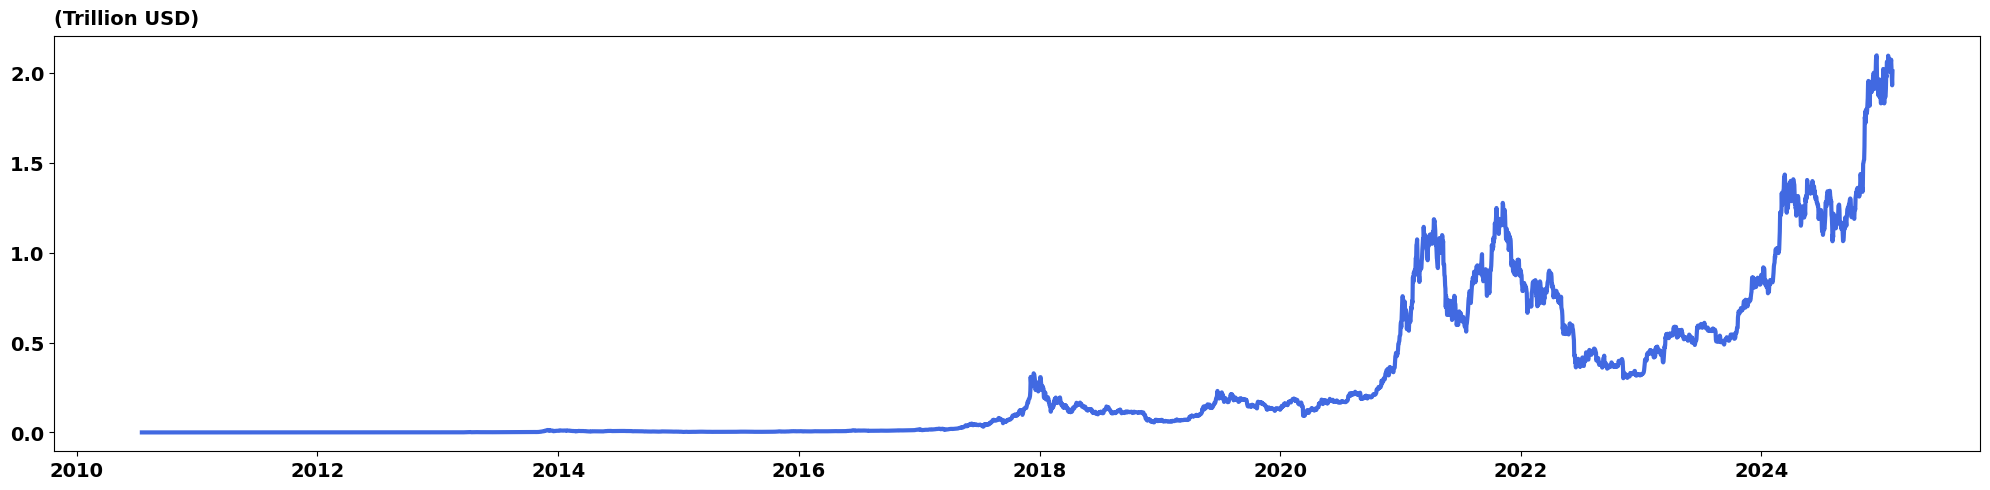

In [3]:
plt.figure(figsize=(20, 5))
plt.plot(df['Market_Cap']/1e12, color='royalblue', linewidth=3)
plt.text(df.index[0] - pd.Timedelta(days=len(df)/20), max(df['Market_Cap']/1e12)+0.15, '(Trillion USD)', fontsize=14, fontweight='heavy', color='black', verticalalignment='bottom', horizontalalignment='left')
plt.xticks(fontsize=14, fontweight='heavy')
plt.yticks(fontsize=14, fontweight='heavy')
plt.tight_layout()
plt.show()

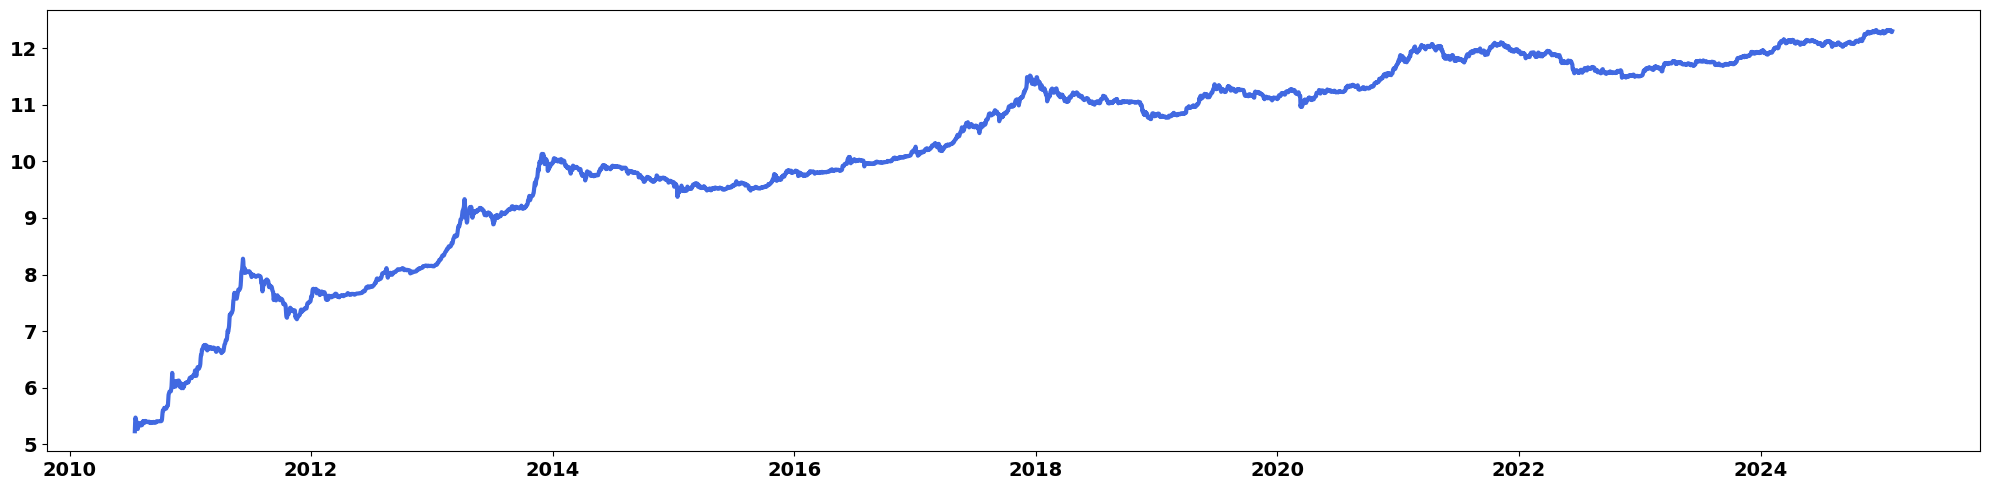

In [4]:
plt.figure(figsize=(20, 5))
plt.plot(np.log10(df['Market_Cap']), color='royalblue', linewidth=3)
# plt.text(df.index[0] - pd.Timedelta(days=len(df)/20), max(df['Market_Cap']/1e12)+14, '(Trillion USD)', fontsize=14, fontweight='heavy', color='black', verticalalignment='bottom', horizontalalignment='left')
plt.xticks(fontsize=14, fontweight='heavy')
plt.yticks(fontsize=14, fontweight='heavy')
plt.tight_layout()
plt.show()

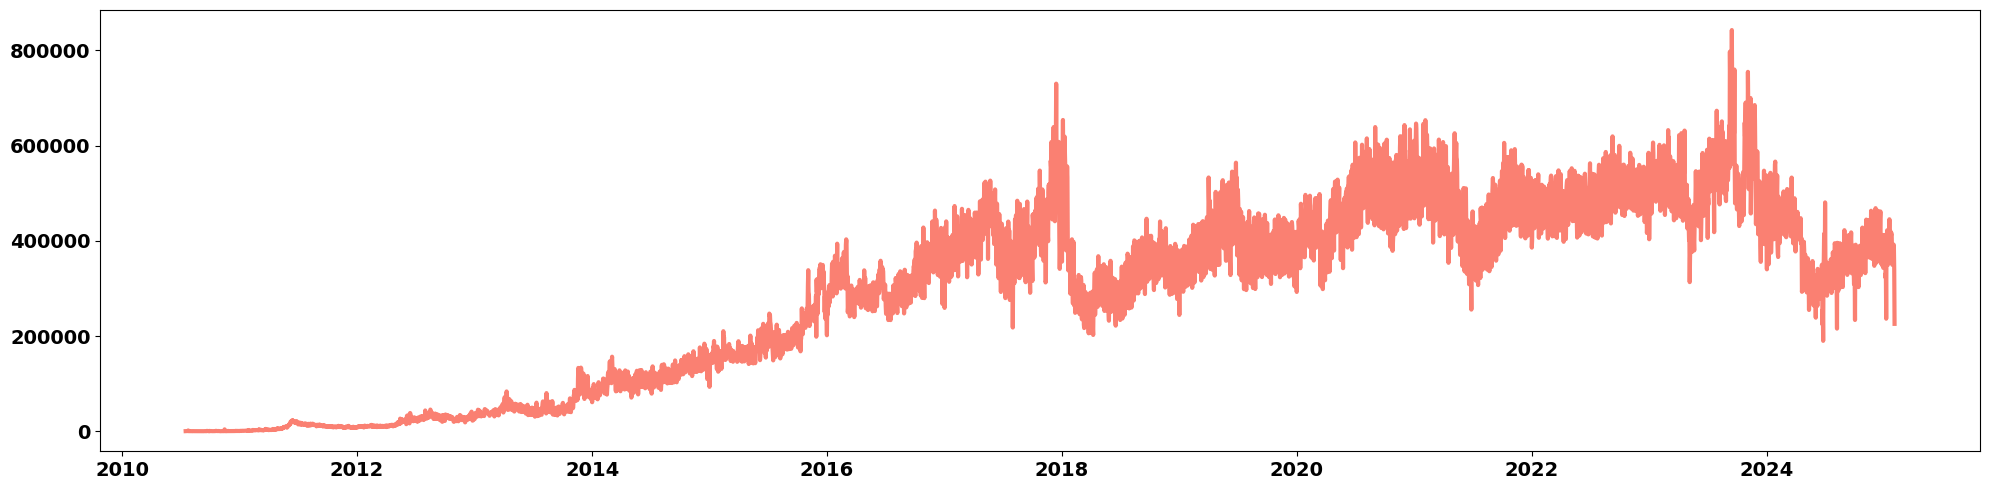

In [5]:
plt.figure(figsize=(20, 5))
plt.plot(df['No_addresses'], color='salmon', linewidth=3)
# plt.text(df.index[0] - pd.Timedelta(days=90), max(df['Market_Cap']/1e12)+14, '(Trillion USD)', fontsize=14, fontweight='heavy', color='black', verticalalignment='bottom', horizontalalignment='left')
plt.xticks(fontsize=14, fontweight='heavy')
plt.yticks(fontsize=14, fontweight='heavy')
plt.tight_layout()
plt.show()

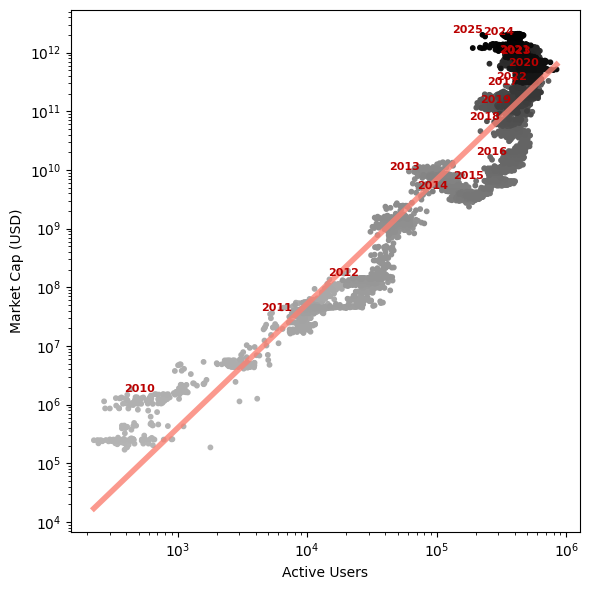

In [ ]:
bw_map = mcolors.LinearSegmentedColormap.from_list('Greys', plt.get_cmap('Greys')(np.linspace(0.4, 1, 256)))

plt.figure(figsize=(6, 6))
plt.scatter(df['No_addresses'], df['Market_Cap'], c=df.index, cmap=bw_map, s=10)

a, b = np.polyfit(np.log10(df['No_addresses']), np.log10(df['Market_Cap']), 1)
x_vals = np.logspace(np.log10(df['No_addresses'].min()), np.log10(df['No_addresses'].max()), 100)
y_vals = 10**(a * np.log10(x_vals) + b)

plt.plot(x_vals, y_vals, color='salmon', linewidth=4, alpha=0.8)

for i, row in df.groupby(df.index.year).last().iterrows():
    plt.text(row['No_addresses'], row['Market_Cap'], str(i), color='#ba0000', fontsize=8, fontweight='heavy', ha='right', va='bottom')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Active Users')
plt.ylabel('Market Cap (USD)')

plt.tight_layout()
plt.savefig('Address-Cap.png', dpi=144, transparent=True)
plt.show()

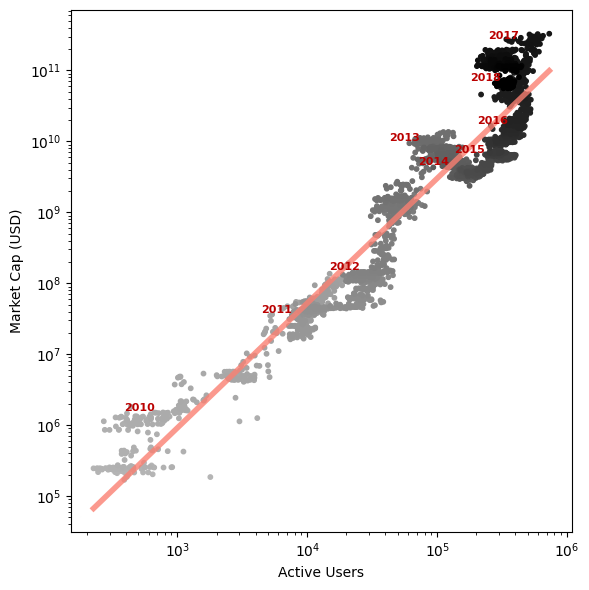

In [10]:
df_2018 = df[df.index.year <= 2018]

plt.figure(figsize=(6, 6))
plt.scatter(df_2018['No_addresses'], df_2018['Market_Cap'], c=df_2018.index, cmap=bw_map, s=10)

a, b = np.polyfit(np.log10(df_2018['No_addresses']), np.log10(df_2018['Market_Cap']), 1)
x_vals = np.logspace(np.log10(df_2018['No_addresses'].min()), np.log10(df_2018['No_addresses'].max()), 100)
y_vals = 10**(a * np.log10(x_vals) + b)

plt.plot(x_vals, y_vals, color='salmon', linewidth=4, alpha=0.8)

for i, row in df_2018.groupby(df_2018.index.year).last().iterrows():
    plt.text(row['No_addresses'], row['Market_Cap'], str(i), color='#ba0000', fontsize=8, fontweight='heavy', ha='right', va='bottom')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Active Users')
plt.ylabel('Market Cap (USD)')

plt.tight_layout()
plt.savefig('Address-Cap 2018.png', dpi=144, transparent=True)
plt.show()

-1.7473924749708214 2.118913116364226


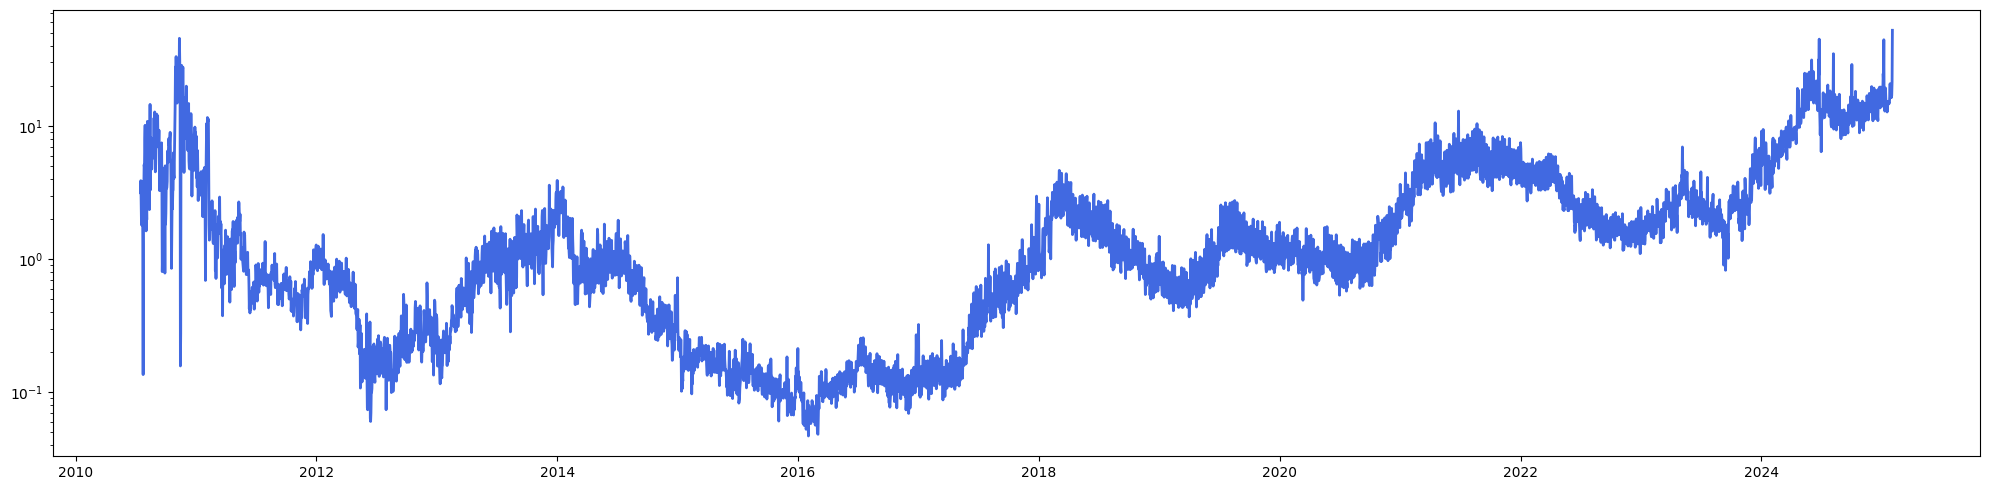

In [331]:
model = sm.OLS(np.log(df['Market_Cap']), sm.add_constant(np.log(df['No_addresses']))).fit()
alpha, beta = model.params
print(alpha, beta)

mmv = df['Market_Cap'] / (np.exp(alpha) * (df['No_addresses'] ** beta))

plt.figure(figsize=(20, 5))
plt.plot(mmv, color='royalblue', linewidth=2)
plt.yscale('log')
plt.tight_layout()
plt.show()

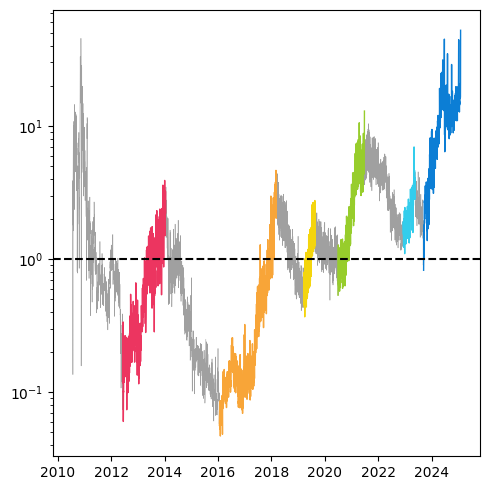

In [310]:
plt.figure(figsize=(5, 5))
plt.plot(mmv.index, mmv, color='#A0A0A0', linewidth=0.4)

bubble_intervals = {
    'Bubble 1': ['2012-06-10', '2014-01-15'],
    'Bubble 2': ['2016-01-20', '2018-03-10'],
    'Bubble 3': ['2019-03-20', '2019-08-20'],
    'Bubble 4': ['2020-07-01', '2021-06-27'],
    'Bubble 5': ['2022-12-10', '2023-05-20'],
    'Bubble 6': ['2023-09-15', '2025-02-02']
}
colors = ['#EC3560', '#F8A538', '#F4D50D', '#97CD2C', '#33CDEC', '#0C7ED5']

for (label, (start, end)), color in zip(bubble_intervals.items(), colors):
    mask = (mmv.index >= pd.to_datetime(start)) & (mmv.index <= pd.to_datetime(end))
    plt.plot(mmv.index[mask], mmv[mask], color=color, linewidth=1, label=label)

plt.axhline(1, color='black', linestyle='--')
plt.yscale('log')
plt.tight_layout()
plt.savefig('MMV.png', dpi=144, transparent=True)
plt.show()

In [335]:
# 找到特定日期的 Market Cap
bubble_dates = ['2012-06-10', '2014-01-15', '2016-01-20', '2018-03-10', 
                '2019-03-20', '2019-08-20', '2020-07-01', '2021-06-27', 
                '2022-12-10', '2023-05-20', '2023-09-15', '2025-02-02']

bubble_market_caps = df.loc[bubble_dates, 'Market_Cap']
bubble_market_caps


Date
2012-06-10    5.067508e+07
2014-01-15    1.028390e+10
2016-01-20    5.700897e+09
2018-03-10    1.608890e+11
2019-03-20    7.017542e+10
2019-08-20    1.810950e+11
2020-07-01    1.676050e+11
2021-06-27    6.477410e+11
2022-12-10    3.288690e+11
2023-05-20    5.191710e+11
2023-09-15    5.173970e+11
2025-02-02    2.011120e+12
Name: Market_Cap, dtype: float64

## Keynote Figure